# Preprocessing and Feature Engineering with scikit-learn Pipelines

This notebook follows the instructor guidance and walks through:

- A manual approach to preprocessing (to show the detailed steps and pitfalls),
- A clean, reproducible approach using scikit-learn `Pipeline` and `ColumnTransformer`.

Dataset: the UCI "Adult" (Census Income) dataset. Task: predict whether income >50K.

## Learning objectives

By the end of this activity you will be able to:

1. Load and inspect a tabular dataset with pandas.
2. Identify numeric vs categorical features and handle missing values.
3. Perform manual preprocessing: imputation, encoding, scaling, and combining features.
4. Build a single, end-to-end `Pipeline` that encapsulates preprocessing and modeling.
5. Appreciate why pipelines prevent data leakage and make models easier to deploy.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print('Libraries imported successfully!')

Libraries imported successfully!


## Load the Adult Census dataset

We fetch the data directly from the UCI repository. The dataset has no header, so we assign column names.

In [3]:
data = pd.read_csv('datasets/adult-census.csv')

print('Dataset loaded. Shape:', data.shape)
data.head()

Dataset loaded. Shape: (48842, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## Part 1 — Manual Approach (Without Pipelines)

We will perform each preprocessing step explicitly to show what a pipeline automates later.

In [ ]:
# Quick EDA - Exploratory Data Analysis
# This shows us data types, non-null counts, and memory usage
# Look for: mixed types, missing values (shown as non-null count < total rows)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   education-num   48842 non-null  int64 
 4   marital-status  48842 non-null  object
 5   occupation      48842 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  48842 non-null  object
 13  class           48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


In [ ]:
# Summary statistics for numeric columns
# This shows mean, std, min, max, and quartiles
# Look for: outliers, scale differences, and distribution patterns
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382
std,13.710510,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
# Check for missing values using pandas isnull()
# Note: This dataset uses ' ?' as a missing value indicator
# pandas won't recognize ' ?' as missing - we need to handle this explicitly
print("Missing values:")
print(data.isnull().sum())

Missing values:
age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64


Target distribution:
class
<=50K    37155
>50K     11687
Name: count, dtype: int64


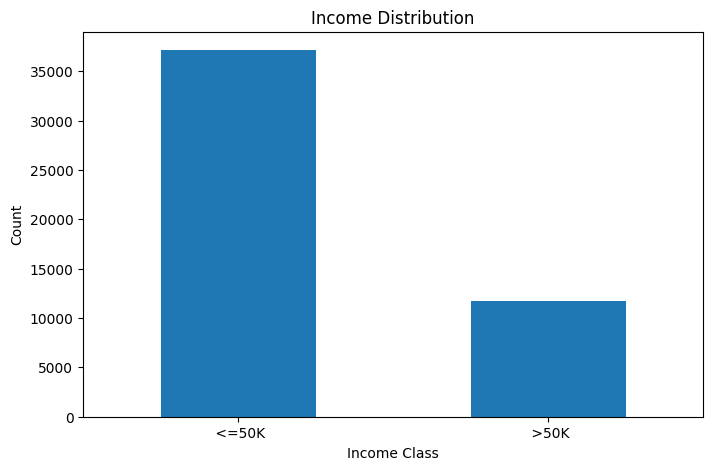

In [ ]:
# Check target distribution
# Important: Check if the dataset is balanced or imbalanced
# This affects model training and evaluation metrics
print("Target distribution:")
print(data['class'].value_counts())

# Visualize target distribution for better understanding
plt.figure(figsize=(8, 5))
data['class'].value_counts().plot(kind='bar')
plt.title('Income Distribution')
plt.xlabel('Income Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Define Feature Types

We need to identify which features are numerical and which are categorical, as they require different preprocessing steps.

In [8]:
# Define numerical features (continuous or discrete numbers)
numerical_features = ['age', 'education-num', 'capital-gain', 
                      'capital-loss', 'hours-per-week']

# Define categorical features (text categories)
categorical_features = ['workclass', 'marital-status', 
                       'occupation', 'relationship', 'race', 'sex', 
                       'native-country']

# Target variable
target = 'class'

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nTarget: {target}")

Numerical features (5): ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Categorical features (7): ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Target: class


### Preprocessing Steps

Our manual preprocessing will follow these steps:

1.  **Handle Missing Values**: The dataset uses `' ?'` to denote missing values. We'll replace these with `NaN` and then use imputation to fill them. For categorical columns, we'll use the most frequent value (mode), and for numerical columns, we'll use the mean.
2.  **Encode Categorical Features**: We will convert categorical text data into a numerical format using one-hot encoding. This creates a new binary column for each category.
3.  **Scale Numerical Features**: To ensure that all features contribute equally to the model, we will scale numerical features to have a mean of 0 and a standard deviation of 1 (Standardization).
4.  **Split Data**: We'll split the data into training and testing sets to evaluate our model's performance on unseen data.

### Step 1: Handle Missing Values

First, let's replace the `' ?'` strings with `NaN` so pandas recognizes them as missing values.

In [ ]:
# Step 1: Replace ' ?' with NaN (Not a Number)
# Why? The dataset uses ' ?' (string with space) to indicate missing values
# We need to convert these to NaN so pandas and sklearn recognize them as missing

data_manual = data.copy()  # Create a copy to preserve original data
data_manual = data_manual.replace(' ?', np.nan)  # Replace all ' ?' with NaN

# Verify the replacement worked by checking for missing values
print("Missing values after replacing ' ?':")
print(data_manual.isnull().sum())
print(f"\nTotal missing values: {data_manual.isnull().sum().sum()}")

Missing values after replacing ' ?':
age                  0
workclass         2799
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64

Total missing values: 6465


Now we can see the actual missing values. Let's visualize their distribution:

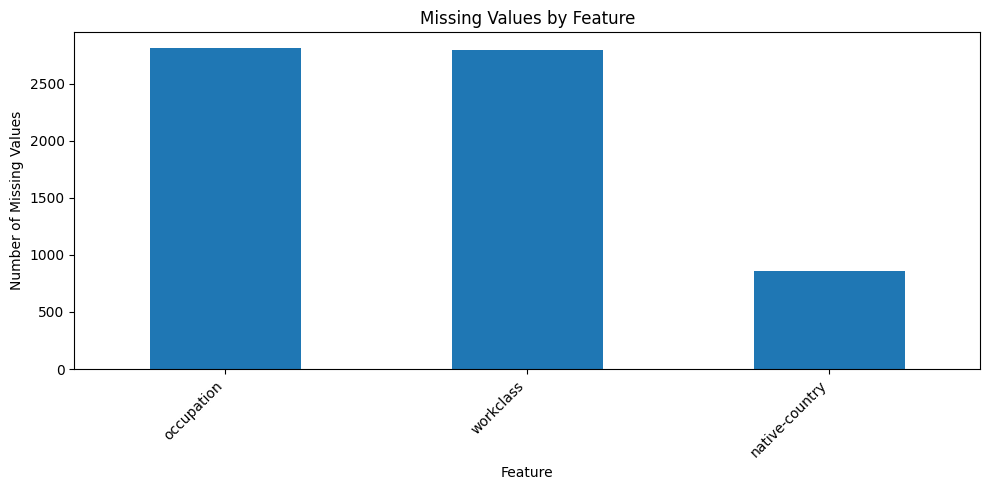

In [ ]:
# Visualize missing values to understand their distribution
# This helps us decide on an imputation strategy

# Get counts of missing values and keep only features with missing data
missing_counts = data_manual.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# Create bar plot
plt.figure(figsize=(10, 5))
missing_counts.plot(kind='bar')
plt.title('Missing Values by Feature')
plt.xlabel('Feature')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Step 2: Split the Data

**Important**: We must split the data BEFORE any preprocessing to avoid data leakage. This is a common mistake that can lead to overly optimistic model performance estimates.

In [ ]:
# Step 1: Separate features (X) from target variable (y)
X = data_manual.drop(columns=[target])  # All columns except 'class'
y = data_manual[target]  # Just the 'class' column

# Step 2: Split into training (80%) and test (20%) sets
# Why split BEFORE preprocessing? To prevent data leakage!
# If we preprocess first, information from test set could leak into training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Keep same class distribution in train and test
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set size: 39073 samples
Test set size: 9769 samples

Training set shape: (39073, 13)
Test set shape: (9769, 13)


### Step 3: Impute Missing Values

Now we'll handle missing values separately for numerical and categorical features. We fit the imputers on the training data and transform both train and test sets.

In [ ]:
# Impute (fill) missing values in NUMERICAL features
# Strategy: Use the MEAN value from the training data
# Why mean? Common choice for numerical data that's roughly normally distributed

# Step 1: Create and FIT the imputer on TRAINING data only
num_imputer = SimpleImputer(strategy='mean')
X_train_num = num_imputer.fit_transform(X_train[numerical_features])

# Step 2: TRANSFORM the test data using the imputer fitted on training data
# Important: We use transform() NOT fit_transform() on test data!
X_test_num = num_imputer.transform(X_test[numerical_features])

# Step 3: Convert numpy arrays back to DataFrames for easier handling
X_train_num = pd.DataFrame(X_train_num, columns=numerical_features, index=X_train.index)
X_test_num = pd.DataFrame(X_test_num, columns=numerical_features, index=X_test.index)

# Verify imputation worked
print("Numerical features after imputation:")
print(f"Training set: {X_train_num.shape}")
print(f"Test set: {X_test_num.shape}")
print(f"Missing values in training numerical features: {X_train_num.isnull().sum().sum()}")

Numerical features after imputation:
Training set: (39073, 5)
Test set: (9769, 5)
Missing values in training numerical features: 0


In [ ]:
# Impute (fill) missing values in CATEGORICAL features
# Strategy: Use the MOST FREQUENT value (mode) from the training data
# Why most frequent? For categories, using the most common value is sensible

# Step 1: Create and FIT the imputer on TRAINING data only
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imputer.fit_transform(X_train[categorical_features])

# Step 2: TRANSFORM the test data (don't fit again!)
X_test_cat = cat_imputer.transform(X_test[categorical_features])

# Step 3: Convert back to DataFrames
X_train_cat = pd.DataFrame(X_train_cat, columns=categorical_features, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=categorical_features, index=X_test.index)

# Verify imputation worked
print("Categorical features after imputation:")
print(f"Training set: {X_train_cat.shape}")
print(f"Test set: {X_test_cat.shape}")
print(f"Missing values in training categorical features: {X_train_cat.isnull().sum().sum()}")

Categorical features after imputation:
Training set: (39073, 7)
Test set: (9769, 7)
Missing values in training categorical features: 0


### Step 4: Scale Numerical Features

We'll standardize numerical features to have mean=0 and standard deviation=1.

In [ ]:
# Scale numerical features using StandardScaler
# What it does: Transforms each feature to have mean=0 and standard deviation=1
# Why? Many ML algorithms perform better when features are on the same scale
# Formula: z = (x - mean) / standard_deviation

# Step 1: Create and FIT scaler on TRAINING data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)

# Step 2: TRANSFORM test data using training statistics
# Critical: Use the SAME mean and std from training, don't calculate new ones!
X_test_num_scaled = scaler.transform(X_test_num)

# Step 3: Convert back to DataFrames
X_train_num_scaled = pd.DataFrame(
    X_train_num_scaled, 
    columns=numerical_features, 
    index=X_train.index
)
X_test_num_scaled = pd.DataFrame(
    X_test_num_scaled, 
    columns=numerical_features, 
    index=X_test.index
)

# Verify scaling worked correctly
print("Numerical features after scaling:")
print("\nMeans (should be close to 0):")
print(X_train_num_scaled.mean().round(10))
print("\nStandard deviations (should be close to 1):")
print(X_train_num_scaled.std().round(10))

Numerical features after scaling:

Means (should be close to 0):
age              -0.0
education-num    -0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week   -0.0
dtype: float64

Standard deviations (should be close to 1):
age               1.000013
education-num     1.000013
capital-gain      1.000013
capital-loss      1.000013
hours-per-week    1.000013
dtype: float64


### Step 5: Encode Categorical Features

We'll use One-Hot Encoding to convert categorical variables into binary columns.

In [ ]:
# One-Hot Encode categorical features
# What it does: Converts each category into a binary (0/1) column
# Example: 'color': ['red', 'blue'] becomes 'color_red': [1,0] and 'color_blue': [0,1]
# Why? ML models need numerical input, can't process text directly

# Step 1: Create and FIT encoder on TRAINING data
# sparse_output=False: Return dense array instead of sparse matrix
# handle_unknown='ignore': If test has new categories, fill with all zeros
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat_encoded = encoder.fit_transform(X_train_cat)

# Step 2: TRANSFORM test data (using categories learned from training)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Step 3: Get the generated feature names
# Example: 'workclass' with value 'Private' becomes 'workclass_Private'
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

print(f"Original categorical features: {len(categorical_features)}")
print(f"Encoded features: {len(encoded_feature_names)}")
print(f"\nFirst 10 encoded feature names:")
print(encoded_feature_names[:10])

Original categorical features: 7
Encoded features: 83

First 10 encoded feature names:
['workclass_ Federal-gov' 'workclass_ Local-gov' 'workclass_ Never-worked'
 'workclass_ Private' 'workclass_ Self-emp-inc'
 'workclass_ Self-emp-not-inc' 'workclass_ State-gov'
 'workclass_ Without-pay' 'marital-status_ Divorced'
 'marital-status_ Married-AF-spouse']


### Step 6: Combine All Features

Now we need to combine the scaled numerical features and the encoded categorical features.

In [ ]:
# Combine numerical and categorical features into single arrays
# np.hstack = horizontal stack (combine columns side-by-side)
# Result: [numerical_features | encoded_categorical_features]

X_train_manual = np.hstack([X_train_num_scaled, X_train_cat_encoded])
X_test_manual = np.hstack([X_test_num_scaled, X_test_cat_encoded])

print(f"Final training set shape: {X_train_manual.shape}")
print(f"Final test set shape: {X_test_manual.shape}")
print(f"\nTotal features: {X_train_manual.shape[1]}")
print(f"  - Numerical features: {len(numerical_features)}")
print(f"  - Encoded categorical features: {len(encoded_feature_names)}")

Final training set shape: (39073, 88)
Final test set shape: (9769, 88)

Total features: 88
  - Numerical features: 5
  - Encoded categorical features: 83


### Step 7: Train and Evaluate Model

Now let's train a Logistic Regression model and evaluate its performance.

In [ ]:
# Train a Logistic Regression model on our preprocessed data
# max_iter=1000: Maximum iterations for the solver to converge
# random_state=42: For reproducible results

# Step 1: Create and train the model
lr_manual = LogisticRegression(max_iter=1000, random_state=42)
lr_manual.fit(X_train_manual, y_train)

# Step 2: Make predictions on both training and test sets
y_train_pred = lr_manual.predict(X_train_manual)
y_test_pred = lr_manual.predict(X_test_manual)

# Step 3: Evaluate performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Manual Preprocessing Approach Results:")
print("=" * 50)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Manual Preprocessing Approach Results:
Training Accuracy: 0.8520
Test Accuracy: 0.8522

Classification Report (Test Set):
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      7431
        >50K       0.74      0.59      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769



### Problems with the Manual Approach

While the manual approach works, it has several issues:

1. **Code Repetition**: We have to repeat similar steps for train and test data
2. **Error Prone**: Easy to accidentally fit on test data or forget to transform
3. **Hard to Maintain**: Changes require updating multiple places
4. **Not Reproducible**: Difficult to apply the same preprocessing to new data
5. **Memory Intensive**: We keep creating intermediate DataFrames
6. **No Guarantee of Consistency**: Parameters learned from training data must be carefully tracked

**Let's see how pipelines solve all these problems!**

---

## Part 2 — Pipeline Approach (The Right Way!)

Now let's rebuild the entire workflow using scikit-learn's `Pipeline` and `ColumnTransformer`. This approach is cleaner, more maintainable, and prevents data leakage.

### Understanding Pipelines

A **Pipeline** chains multiple steps into a single estimator. The key benefits are:

- **Convenience**: Apply all steps with a single `fit()` and `predict()` call
- **Safety**: Ensures transformers are fit only on training data
- **Reproducibility**: Easy to save and load the entire preprocessing + model
- **Grid Search**: Can tune hyperparameters across all steps together

A **ColumnTransformer** allows applying different transformations to different columns, which is perfect for handling numerical and categorical features separately.

### Step 1: Prepare Fresh Data

Let's start fresh with the original data.

In [ ]:
# Prepare data for pipeline approach (starting fresh)
# We'll do the same preprocessing, but in a cleaner, automated way

# Step 1: Copy and clean the data
data_pipeline = data.copy()
data_pipeline = data_pipeline.replace(' ?', np.nan)  # Replace missing value indicator

# Step 2: Separate features and target
X_pipeline = data_pipeline.drop(columns=[target])
y_pipeline = data_pipeline[target]

# Step 3: Split into train and test (using same parameters for fair comparison)
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
    X_pipeline, y_pipeline, 
    test_size=0.2, 
    random_state=42,  # Same random state = same split
    stratify=y_pipeline
)

print(f"Pipeline approach - Data prepared")
print(f"Training set: {X_train_pipe.shape}")
print(f"Test set: {X_test_pipe.shape}")

Pipeline approach - Data prepared
Training set: (39073, 13)
Test set: (9769, 13)


### Step 2: Build Preprocessing Pipelines

We'll create separate pipelines for numerical and categorical features.

In [ ]:
# Create preprocessing pipelines for each feature type
# A Pipeline chains multiple steps: each step's output becomes the next step's input

# Numerical Pipeline: 
# Step 1: Impute missing values with mean
# Step 2: Scale to mean=0, std=1
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline:
# Step 1: Impute missing values with most frequent category
# Step 2: One-hot encode categories into binary columns
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

print("Preprocessing pipelines created:")
print(f"\nNumerical Pipeline:")
print(numerical_pipeline)
print(f"\nCategorical Pipeline:")
print(categorical_pipeline)

Preprocessing pipelines created:

Numerical Pipeline:
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

Categorical Pipeline:
Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


### Step 3: Combine with ColumnTransformer

The `ColumnTransformer` applies different pipelines to different columns.

In [ ]:
# Combine both pipelines using ColumnTransformer
# ColumnTransformer applies different transformations to different columns
# Format: (name, transformer, columns)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),      # Apply numerical_pipeline to numerical features
        ('cat', categorical_pipeline, categorical_features)   # Apply categorical_pipeline to categorical features
    ],
    remainder='drop'  # Drop any columns not specified (we've specified all of them)
)

print("ColumnTransformer created:")
print(preprocessor)

ColumnTransformer created:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'education-num', 'capital-gain',
                                  'capital-loss', 'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['workclass', 'marital-status', 'occupation',
                                  'relationship', 'race', 'sex',
                                  'native-country'])]

### Step 4: Create End-to-End Pipeline

Now we'll create a complete pipeline that includes both preprocessing and the model.

In [ ]:
# Create a FULL end-to-end pipeline that does EVERYTHING:
# 1. Preprocessing (imputation, scaling, encoding)
# 2. Model training and prediction

# This is the power of pipelines: one object handles the entire workflow!
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # All the preprocessing steps
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # The model
])

print("Complete Pipeline:")
print(full_pipeline)
print("\n" + "="*60)
print("Pipeline Structure:")
print("="*60)
for step_name, step in full_pipeline.steps:
    print(f"\nStep: {step_name}")
    print(f"  Type: {type(step).__name__}")
    if hasattr(step, 'transformers'):
        print(f"  Transformers: {len(step.transformers)}")

Complete Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                       

### Step 5: Train the Pipeline

With a pipeline, training is just one line of code! The pipeline will:
1. Fit the imputers on training data
2. Transform the training data with the fitted imputers
3. Fit the scalers/encoders on the transformed training data
4. Transform the training data again
5. Fit the classifier on the final transformed training data

In [22]:
# Train the pipeline - just one line!
full_pipeline.fit(X_train_pipe, y_train_pipe)

print("Pipeline trained successfully!")
print("\nThe pipeline has learned:")
print("  - How to impute missing values (from training data)")
print("  - How to scale numerical features (from training data)")
print("  - Which categories exist (from training data)")
print("  - The logistic regression coefficients")

Pipeline trained successfully!

The pipeline has learned:
  - How to impute missing values (from training data)
  - How to scale numerical features (from training data)
  - Which categories exist (from training data)
  - The logistic regression coefficients


### Step 6: Make Predictions

Making predictions is also just one line! The pipeline automatically applies all preprocessing steps using the parameters learned from training data.

In [23]:
# Make predictions - also just one line!
y_train_pred_pipe = full_pipeline.predict(X_train_pipe)
y_test_pred_pipe = full_pipeline.predict(X_test_pipe)

# Evaluate
train_accuracy_pipe = accuracy_score(y_train_pipe, y_train_pred_pipe)
test_accuracy_pipe = accuracy_score(y_test_pipe, y_test_pred_pipe)

print("Pipeline Approach Results:")
print("=" * 50)
print(f"Training Accuracy: {train_accuracy_pipe:.4f}")
print(f"Test Accuracy: {test_accuracy_pipe:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test_pipe, y_test_pred_pipe))

Pipeline Approach Results:
Training Accuracy: 0.8520
Test Accuracy: 0.8522

Classification Report (Test Set):
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      7431
        >50K       0.74      0.59      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769



### Step 7: Compare Results

Let's verify that both approaches give the same results.

In [24]:
# Compare results
comparison_df = pd.DataFrame({
    'Approach': ['Manual', 'Pipeline'],
    'Training Accuracy': [train_accuracy, train_accuracy_pipe],
    'Test Accuracy': [test_accuracy, test_accuracy_pipe]
})

print("Results Comparison:")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("\n" + "=" * 60)
print("✓ Both approaches produce identical results!")
print("✓ But the pipeline approach is cleaner, safer, and more maintainable.")

Results Comparison:
Approach  Training Accuracy  Test Accuracy
  Manual           0.851995       0.852185
Pipeline           0.851995       0.852185

✓ Both approaches produce identical results!
✓ But the pipeline approach is cleaner, safer, and more maintainable.


---

## Advanced Pipeline Features

Let's explore some powerful features of pipelines.

### 1. Accessing Pipeline Components

You can access individual steps in the pipeline to inspect their learned parameters.

In [ ]:
# Access and inspect the learned parameters from the pipeline
# This shows us what the pipeline learned during training

# Access the preprocessor step
preprocessor_fitted = full_pipeline.named_steps['preprocessor']

# Navigate to the numerical transformer and get the scaler
numerical_transformer = preprocessor_fitted.named_transformers_['num']
scaler_fitted = numerical_transformer.named_steps['scaler']

# Display the learned mean and standard deviation for each numerical feature
print("Learned scaling parameters for numerical features:")
print("=" * 60)
for feature, mean, scale in zip(numerical_features, scaler_fitted.mean_, scaler_fitted.scale_):
    print(f"{feature:20s} - Mean: {mean:10.2f}, Std: {scale:10.2f}")

# Navigate to the categorical transformer and get the encoder
categorical_transformer = preprocessor_fitted.named_transformers_['cat']
encoder_fitted = categorical_transformer.named_steps['encoder']

# Display the number of categories found in each categorical feature
print("\n\nNumber of categories per feature:")
print("=" * 60)
for feature, categories in zip(categorical_features, encoder_fitted.categories_):
    print(f"{feature:20s} - {len(categories)} categories")
        
# Show an example of the actual categories for one feature
print("\n\nExample - Categories in 'workclass':")
print(encoder_fitted.categories_[0])

Learned scaling parameters for numerical features:
age                  - Mean:      38.70, Std:      13.74
education-num        - Mean:      10.08, Std:       2.57
capital-gain         - Mean:    1057.47, Std:    7332.41
capital-loss         - Mean:      89.95, Std:     408.62
hours-per-week       - Mean:      40.46, Std:      12.42


Number of categories per feature:
workclass            - 8 categories
marital-status       - 7 categories
occupation           - 14 categories
relationship         - 6 categories
race                 - 5 categories
sex                  - 2 categories
native-country       - 41 categories


Example - Categories in 'workclass':
[' Federal-gov' ' Local-gov' ' Never-worked' ' Private' ' Self-emp-inc'
 ' Self-emp-not-inc' ' State-gov' ' Without-pay']


### 2. Predicting on New Data

One of the biggest advantages of pipelines is that you can easily apply the same preprocessing to new data.

In [ ]:
# Demonstrate how easy it is to make predictions on completely new data
# The pipeline automatically applies ALL preprocessing steps!

# Create a sample data point representing a new person
new_person = pd.DataFrame([{
    'age': 35,
    'workclass': ' Private',
    'education-num': 13,
    'marital-status': ' Married-civ-spouse',
    'occupation': ' Prof-specialty',
    'relationship': ' Husband',
    'race': ' White',
    'sex': ' Male',
    'capital-gain': 0,
    'capital-loss': 0,
    'hours-per-week': 40,
    'native-country': ' United-States'
}])

print("New person data:")
print(new_person.T)  # Transpose for better display

# Make prediction - pipeline handles all preprocessing automatically!
# It will: impute if needed, scale numerics, encode categoricals, then predict
prediction = full_pipeline.predict(new_person)
prediction_proba = full_pipeline.predict_proba(new_person)

print("\n" + "=" * 60)
print(f"Prediction: {prediction[0]}")
print(f"Probability of <=50K: {prediction_proba[0][0]:.4f}")
print(f"Probability of >50K: {prediction_proba[0][1]:.4f}")

New person data:
                                  0
age                              35
workclass                   Private
education-num                    13
marital-status   Married-civ-spouse
occupation           Prof-specialty
relationship                Husband
race                          White
sex                            Male
capital-gain                      0
capital-loss                      0
hours-per-week                   40
native-country        United-States

Prediction:  >50K
Probability of <=50K: 0.4689
Probability of >50K: 0.5311


### 3. Saving and Loading Pipelines

Pipelines can be easily saved and loaded using joblib or pickle.

In [ ]:
# Save and load pipelines for deployment
# This is crucial for production: save once, load anywhere!
import joblib

# Save the ENTIRE pipeline (preprocessing + model) to a file
# This includes all learned parameters: imputation values, scaling factors, categories, coefficients
joblib.dump(full_pipeline, 'income_prediction_pipeline.pkl')
print("Pipeline saved to 'income_prediction_pipeline.pkl'")

# Load the pipeline back from disk
# Now you can use this in a web app, API, or different environment
loaded_pipeline = joblib.load('income_prediction_pipeline.pkl')
print("Pipeline loaded successfully!")

# Verify the loaded pipeline works exactly like the original
test_prediction = loaded_pipeline.predict(new_person)
print(f"\nPrediction from loaded pipeline: {test_prediction[0]}")
print("✓ Loaded pipeline works perfectly!")

Pipeline saved to 'income_prediction_pipeline.pkl'
Pipeline loaded successfully!

Prediction from loaded pipeline:  >50K
✓ Loaded pipeline works perfectly!


### 4. Hyperparameter Tuning with GridSearchCV

Pipelines integrate seamlessly with cross-validation and hyperparameter tuning.

In [ ]:
# Hyperparameter tuning with GridSearchCV and Pipelines
# GridSearchCV tries different parameter combinations and picks the best one
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search
# Format: 'stepname__substep__parameter': [values to try]
# We can tune BOTH preprocessing AND model parameters!
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],  # Try different imputation strategies
    'classifier__C': [0.1, 1.0, 10.0],  # Try different regularization strengths
    'classifier__penalty': ['l2']  # Keep L2 regularization
}

# Create GridSearchCV object
# cv=3: Use 3-fold cross-validation
# n_jobs=-1: Use all CPU cores
grid_search = GridSearchCV(
    full_pipeline,  # The entire pipeline to tune
    param_grid,     # Parameters to try
    cv=3,           # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,      # Parallel processing
    verbose=1       # Show progress
)

print("Starting Grid Search...")
print("This will try different combinations of preprocessing and model parameters")
print(f"Total combinations: {len(param_grid['preprocessor__num__imputer__strategy']) * len(param_grid['classifier__C'])}")

# Fit grid search - this trains multiple models and picks the best
# For each combination, it does 3-fold CV, so total fits = combinations × 3
grid_search.fit(X_train_pipe, y_train_pipe)

print("\n" + "=" * 60)
print("Grid Search Complete!")
print("=" * 60)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Test set score: {grid_search.score(X_test_pipe, y_test_pipe):.4f}")

Starting Grid Search...
This will try different combinations of preprocessing and model parameters
Total combinations: 6
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Grid Search Complete!
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'preprocessor__num__imputer__strategy': 'mean'}
Best cross-validation score: 0.8509
Test set score: 0.8522

Grid Search Complete!
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'preprocessor__num__imputer__strategy': 'mean'}
Best cross-validation score: 0.8509
Test set score: 0.8522


---

## Summary and Best Practices

Let's recap what we've learned about preprocessing and pipelines.

### Key Takeaways

#### Manual Preprocessing
✗ **Pros:**
- Easy to understand step-by-step
- Good for learning the concepts
- More control over each step

✗ **Cons:**
- Error-prone (easy to introduce data leakage)
- Lots of repetitive code
- Hard to maintain and update
- Difficult to deploy to production
- Parameters must be manually tracked

#### Pipeline Approach
✓ **Pros:**
- **Prevents data leakage** by design
- **Clean and concise** code
- **Easy to maintain** and update
- **Reproducible** - can apply to new data easily
- **Production-ready** - just save and load
- **Integrates with cross-validation** and hyperparameter tuning
- **Guarantees consistency** between training and prediction

✓ **Cons:**
- Requires understanding of the pipeline API
- Slightly less transparent (abstraction)

### Best Practices for Data Preprocessing

1. **Always split data BEFORE preprocessing** to avoid data leakage
2. **Use pipelines** for any non-trivial preprocessing workflow
3. **Use ColumnTransformer** when you have different feature types
4. **Fit transformers only on training data**, then transform both train and test
5. **Save your pipelines** for deployment and reproducibility
6. **Document your preprocessing choices** (why you chose mean vs median, etc.)
7. **Test on new data** to ensure your pipeline generalizes
8. **Use cross-validation** to validate your preprocessing choices
9. **Version your pipelines** along with your models
10. **Monitor for data drift** in production

### Common Pitfalls to Avoid

#### ❌ Data Leakage
```python
# WRONG: Scaling before splitting
scaler.fit(X)  # Uses ALL data including test set!
X_scaled = scaler.transform(X)
X_train, X_test = train_test_split(X_scaled)

# CORRECT: Split first, then fit on training only
X_train, X_test = train_test_split(X)
scaler.fit(X_train)  # Only uses training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

#### ❌ Inconsistent Preprocessing
```python
# WRONG: Different preprocessing for train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)  # Fitting again!

# CORRECT: Fit once, transform both
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)  # Just transform
```

#### ❌ Forgetting Preprocessing Steps
```python
# WRONG: Easy to forget a step
prediction = model.predict(new_data)  # Forgot to scale!

# CORRECT: Pipeline handles everything
prediction = pipeline.predict(new_data)  # Automatically scales
```

---

## Practice Exercises

Try these exercises to test your understanding:

### Exercise 1: Modify the Pipeline
Create a new pipeline that uses:
- Median imputation for numerical features instead of mean
- `MinMaxScaler` instead of `StandardScaler`
- Compare the results with the original pipeline

### Exercise 2: Add Feature Engineering
Extend the pipeline to:
- Create a new feature: `capital-diff = capital-gain - capital-loss`
- Create age groups: `young (<30)`, `middle (30-60)`, `senior (>60)`
- Add these features before the model

### Exercise 3: Try Different Models
Replace the Logistic Regression with:
- Random Forest Classifier
- Gradient Boosting Classifier
- Support Vector Machine
Compare their performance

### Exercise 4: Handle Unknown Categories
Test what happens when new data contains categories not seen during training:
- Create a sample with a fake country or occupation
- See how `handle_unknown='ignore'` handles it
- Try `handle_unknown='error'` to see the difference

### Exercise 5: Feature Selection in Pipeline
Add a feature selection step:
- Use `SelectKBest` or `SelectFromModel`
- Place it after preprocessing but before the classifier
- Find the optimal number of features using GridSearchCV

## Additional Resources

### Documentation
- [scikit-learn Pipeline Documentation](https://scikit-learn.org/stable/modules/compose.html)
- [ColumnTransformer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- [Preprocessing Guide](https://scikit-learn.org/stable/modules/preprocessing.html)

### Further Reading
- **Why pipelines matter**: They prevent data leakage and make ML workflows reproducible
- **Production ML**: Pipelines are essential for deploying models to production
- **MLOps**: Version control for pipelines using DVC, MLflow, or similar tools

### Next Steps
1. Learn about custom transformers (make your own preprocessing steps)
2. Explore `make_pipeline()` for simpler pipeline creation
3. Study `FeatureUnion` for parallel feature processing
4. Practice with different datasets and preprocessing strategies

---

**Congratulations!** You now understand both the manual and pipeline approaches to data preprocessing. Always prefer pipelines in real projects - your future self will thank you! 🎉